### Importing the necessary libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd

In [3]:
from PIL import Image, ImageOps,ExifTags

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import matplotlib.pyplot as plt

### Step 1: Load  data


In [6]:
train_image_path = "img_dataset/train/"
train_labels_path = "img_dataset/train/_classes.csv"

In [7]:
valid_image_path = "img_dataset/valid/"
valid_labels_path = "img_dataset/valid/_classes.csv"

In [8]:
train_labels=pd.read_csv(train_labels_path)
train_labels

,filename,Fresh,Half-Fresh,Spoiled
0,SPOILED-207-_JPG.rf.4e9025c18a5ae21defb30242a6...,0,0,1
1,SPOILED-261-_JPG.rf.4effa4dd0d8c2fe5579aa5859e...,0,0,1
2,FRESH-202-_JPG.rf.4f13e1b8c1559b63d140d2942697...,1,0,0
3,FRESH-721-_JPG.rf.4f770a93bd104098aa7ffb172a90...,1,0,0
4,FRESH-904-_JPG.rf.4f66185dbff0f068ed39414bfdf1...,1,0,0
...,...,...,...,...
1810,SPOILED-263-_JPG.rf.eef959c9ba893274d666169178...,0,0,1
1811,HALF-FRESH-32-_JPG.rf.ef030046a930f7817929dc92...,0,1,0
1812,FRESH-925-_JPG.rf.ef213edbfb3cd9e346edf4c39316...,1,0,0
1813,HALF-FRESH-91-_JPG.rf.ef3a807f322cb81542715d6c...,0,1,0


In [9]:
valid_labels=pd.read_csv(valid_labels_path)
valid_labels

,filename,Fresh,Half-Fresh,Spoiled
0,HALF-FRESH-8-_JPG.rf.5bf1ec7ab3a5bca8b3a01bbd3...,0,1,0
1,FRESH-91-_JPG.rf.5ce4d7d669bae2d26735e4edf0a17...,1,0,0
2,FRESH-408-_JPG.rf.5ead7613098bae61f4a33fab1084...,1,0,0
3,FRESH-344-_JPG.rf.5e8ec1875092af8f909b876ee314...,1,0,0
4,HALF-FRESH-919-_JPG.rf.5f00a599bb9c9b7694db119...,0,1,0
...,...,...,...,...
446,SPOILED-490-_JPG.rf.56a0be42dae8e67015a027f8da...,0,0,1
447,SPOILED-189-_JPG.rf.557a72188a67f78d2335f67cef...,0,0,1
448,FRESH-338-_JPG.rf.58b3eb5a892b4e2201209243b0df...,1,0,0
449,SPOILED-26-_JPG.rf.59b69017d91e0af8f36accf2d71...,0,0,1


In [10]:
# view the images
def image(image_path, title="Image"):
    """ Function to display an image using matplotlib """
    img = Image.open(image_path)  # Read the image using PIL
    img = ImageOps.exif_transpose(img)  # Auto-orient based on EXIF data
    plt.imshow(img)  # Display the image
    plt.title(title)  # Add a title
    plt.axis('off')  # Remove axes
    plt.show()

def show_image(folder_path, index):
    """ Show an image from the folder based on its index """
    # Get the list of image files in the folder (filtering for common image formats)
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))]
    
    if index < 0 or index >= len(image_files):
        print(f"Invalid index: {index}. Please provide a valid index between 0 and {len(image_files)-1}.")
        return
    
    # Get the image file based on the index
    image_file = image_files[index]
    image_path = os.path.join(folder_path, image_file)
    
    print(f"Displaying {image_file} at index {index}...")
    image(image_path)

Displaying FRESH-650-_JPG.rf.bfe1fd8bf6beafd108789463662feca4.jpg at index 10...


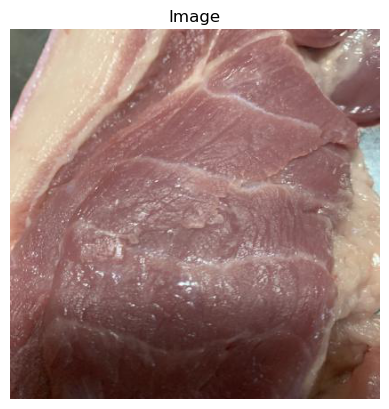

In [11]:
show_image(train_image_path, 10)

Displaying FRESH-4-_JPG.rf.3d59805c3f34b360e1b79ac8955714db.jpg at index 10...


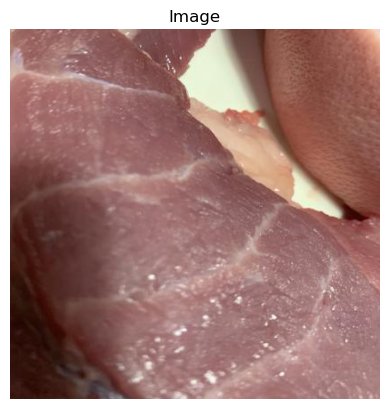

In [12]:
show_image(valid_image_path, 10)

### Step 2: Preprocess data

In [13]:
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess an image:
    - Auto-orient the image based on EXIF data.
    - Resize the image to the specified target size.
    - Normalize the pixel values.
    """
    img = Image.open(image_path)
    img = ImageOps.exif_transpose(img)  # Auto-orient
    img = img.resize(target_size)      # Resize
    img_array = np.array(img)          # Convert to numpy array
    img_array = img_array.astype('float32') / 255.0  # Normalize
    return img_array
def process_images(image_dir, labels_df, target_size=(224, 224)):
    """
    Process all images and labels:
    - Load images using filenames from the DataFrame.
    - Apply preprocessing.
    - Convert one-hot encoded labels to numpy arrays.
    """
    images = []
    labels = []
    labels_df.columns = labels_df.columns.str.strip()
    
    for index, row in labels_df.iterrows():
        image_name = row['filename']
        image_path = os.path.join(image_dir, image_name)

        # Ensure the image file exists before processing
        if not os.path.exists(image_path):
            print(f"Warning: File {image_name} does not exist.")
            continue

        # Preprocess the image
        img = preprocess_image(image_path, target_size)
        images.append(img)

        # Extract one-hot encoded labels
        label = [row['Fresh'], row['Half-Fresh'], row['Spoiled']]
        labels.append(label)

    return np.array(images), np.array(labels)

In [14]:
target_size=(224, 224)

In [15]:
train_images, train_labels = process_images(train_image_path, train_labels)
valid_images, valid_labels = process_images(valid_image_path, valid_labels)

print(f"Processed {len(train_images)} training images.")
print(f"Processed {len(valid_images)} validation images.")

Processed 1815 training images.
Processed 451 validation images.


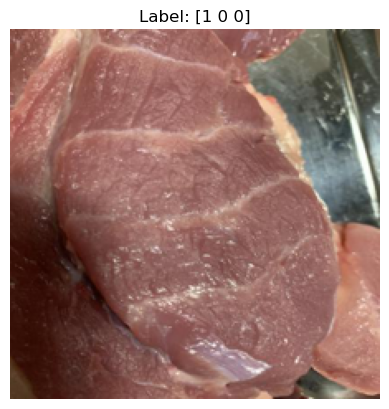

In [16]:
plt.imshow(train_images[9])  # Display the  image at index 9
plt.title(f"Label: {train_labels[9]}")  # Display the label of the image
plt.axis('off')  # Turn off axes
plt.show()

In [17]:
input_shape=train_images[9].shape
input_shape

(224, 224, 3)

In [18]:
train_labels[9]

array([1, 0, 0])

### Step 3: Model setup

In [19]:

# Define the MobileNetV2 base model with pre-trained weights
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
base_model.trainable = False  # Freeze the pre-trained layers


2024-12-21 16:10:16.118695: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-12-21 16:10:16.118738: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-21 16:10:16.118754: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-21 16:10:16.119034: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-21 16:10:16.119398: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
# Add custom layers on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 output classes: Fresh, Half-Fresh, Spoiled
])


In [21]:
# Compile the model 
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Step 4: Train the model

In [22]:

# Define callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.2, verbose=1)
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)

# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(valid_images, valid_labels),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/20


2024-12-21 16:10:19.933719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - ETA: 0s - loss: 13.4051 - accuracy: 0.7697

/Users/shaynatuscano/anaconda3/envs/gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - 10s 103ms/step - loss: 13.4051 - accuracy: 0.7697 - val_loss: 1.4765 - val_accuracy: 0.9313 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - 4s 78ms/step - loss: 2.2265 - accuracy: 0.9438 - val_loss: 0.8727 - val_accuracy: 0.9579 - lr: 0.0010
Epoch 3/20
57/57 [==============================] - 4s 63ms/step - loss: 0.5248 - accuracy: 0.9730 - val_loss: 1.4471 - val_accuracy: 0.9446 - lr: 0.0010
Epoch 4/20
57/57 [==============================] - 4s 76ms/step - loss: 0.3933 - accuracy: 0.9813 - val_loss: 0.2977 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 5/20
57/57 [==============================] - 4s 67ms/step - loss: 0.6775 - accuracy: 0.9796 - val_loss: 3.0380 - val_accuracy: 0.9002 - lr: 0.0010
Epoch 6/20
57/57 [==============================] - 4s 77ms/step - loss: 0.3009 - accuracy: 0.9824 - val_loss: 0.6381 - val_accuracy: 0.9734 - lr: 0.0010
Epoch 7/20
57/57 [==============================] - ETA: 0s - loss: 0.2856 - accurac

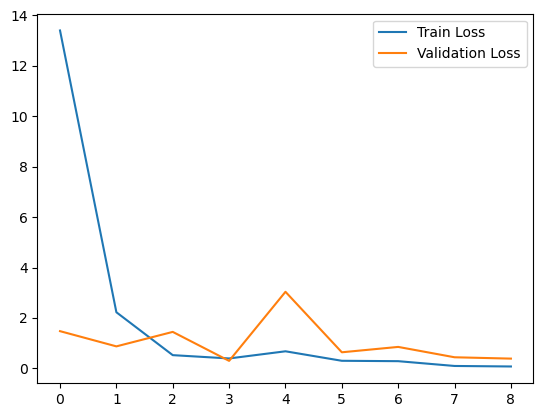

In [23]:
#Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### Step 5: Convert the trained model to TensorFlow Lite

In [24]:

def convert_to_tflite(keras_model, output_path):
    """Converts a Keras model to TFLite format."""
    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    tflite_model = converter.convert()
    with open(output_path, "wb") as f:
        f.write(tflite_model)
    print("Model successfully converted to TFLite format.")

In [25]:
model_path = 'model.tflite'

In [26]:
# Convert and save as TFLite model
convert_to_tflite(model, model_path)

INFO:tensorflow:Assets written to: /var/folders/w4/kwb15vdn36j4c1m49tjf_s140000gn/T/tmp0jfu5gju/assets


INFO:tensorflow:Assets written to: /var/folders/w4/kwb15vdn36j4c1m49tjf_s140000gn/T/tmp0jfu5gju/assets
2024-12-21 16:11:08.800275: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-12-21 16:11:08.800288: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-12-21 16:11:08.801093: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/w4/kwb15vdn36j4c1m49tjf_s140000gn/T/tmp0jfu5gju
2024-12-21 16:11:08.811082: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-12-21 16:11:08.811089: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/w4/kwb15vdn36j4c1m49tjf_s140000gn/T/tmp0jfu5gju
2024-12-21 16:11:08.830333: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-12-21 16:11:08.836271: I tensorflow/cc/saved_model/load

Model successfully converted to TFLite format.


### Step 6: Load and test the TFLite model

In [27]:
def preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)  # Resize the image
    image = img_to_array(image)  # Convert to numpy array
    image = image / 255.0  # Normalize to range [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def predict_with_tflite(interpreter, image_path):
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], preprocessed_image)

    # Run inference
    interpreter.invoke()

    # Get output tensor (prediction results)
    predictions = interpreter.get_tensor(output_details[0]['index'])
    return predictions

# Map predicted output to human-readable labels
def interpret_output(predictions, class_labels):
    predicted_index = np.argmax(predictions[0])  # Get the class with the highest confidence
    predicted_label = class_labels[predicted_index]
    confidence = predictions[0][predicted_index] * 100
    return predicted_label, confidence
class_labels = ["Fresh", "Half-Fresh", "Spoiled"]  # Labels for classes

In [39]:
image_test_path = "img_dataset/test/TopOfTheRibFatCap2__79645.jpg"

In [40]:
img = Image.open(image_test_path)

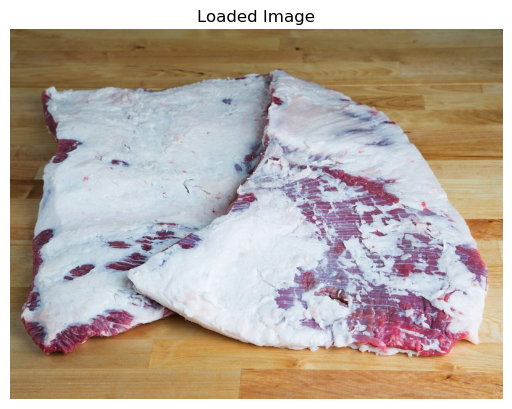

In [41]:
#view the test image
plt.imshow(img)
plt.axis('off')  # Hide the axes for better visualization
plt.title("Loaded Image")  # Optional: add a title
plt.show()

In [42]:


def preprocess_test_image(image_test_path, target_size=(224, 224)):
    """
    Preprocess the image to make it compatible with the TFLite model.
    """
    # Load the image from the file path and resize it
    image = load_img(image_test_path, target_size=target_size)
    
    # Convert the image to a numpy array
    image = img_to_array(image)
    
    # Normalize pixel values to the range [0, 1]
    image = image / 255.0
    
    # Add a batch dimension (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)

    return image


In [43]:
def load_tflite_model(model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    return interpreter


In [44]:
# Load TFLite model
interpreter = load_tflite_model(model_path)


In [45]:
predictions = predict_with_tflite(interpreter, image_test_path)

In [46]:
predictions

array([[1.4953502e-35, 1.9389477e-27, 1.0000000e+00]], dtype=float32)

In [47]:
label, confidence = interpret_output(predictions, class_labels)
print(f"Predicted Label: {label}, Confidence: {confidence:.2f}%")

Predicted Label: Spoiled, Confidence: 100.00%
